In [1]:
import os
import tempfile
import configparser
import redis
import utils
import json
import utils
import json

Loading metadata......Done
Loading network......Done


In [2]:
cfg = os.path.join("config.ini")

config = configparser.ConfigParser()
config.read(cfg)

databases = dict()
for key in config["redis"].keys():
    if key in ["host", "port"]:
        continue
    db_ = redis.StrictRedis(
        host=config["redis"]["host"],
        port=config["redis"]["port"],
        db=config["redis"][key],
    )
    databases[key] = db_

# Hack
class RedisDb(object):
    def __init__(self):
        pass
redis_db = RedisDb()
for key,value in databases.items():
    setattr(redis_db, key, value)
    
def flush_keys():
    for db_name, db in databases.items():
        db.flushdb()
        print("{} db: flushing".format(db_name))
    db.flushall()

def key_count():
    for db_name, db in databases.items():
        print("{} db: {} keys".format(db_name, db.dbsize()))
        
databases

{'rq': StrictRedis<ConnectionPool<Connection<host=127.0.0.1,port=6379,db=60>>>,
 'rq_thumb': StrictRedis<ConnectionPool<Connection<host=127.0.0.1,port=6379,db=61>>>,
 'rq_cache': StrictRedis<ConnectionPool<Connection<host=127.0.0.1,port=6379,db=62>>>,
 'xxhash': StrictRedis<ConnectionPool<Connection<host=127.0.0.1,port=6379,db=11>>>,
 'exif': StrictRedis<ConnectionPool<Connection<host=127.0.0.1,port=6379,db=12>>>,
 'thumb': StrictRedis<ConnectionPool<Connection<host=127.0.0.1,port=6379,db=13>>>,
 'objects': StrictRedis<ConnectionPool<Connection<host=127.0.0.1,port=6379,db=14>>>}

In [3]:
key_count()

rq db: 0 keys
rq_thumb db: 0 keys
rq_cache db: 0 keys
xxhash db: 7 keys
exif db: 0 keys
thumb db: 7 keys
objects db: 1 keys


In [4]:
flush_keys()

rq db: flushing
rq_thumb db: flushing
rq_cache db: flushing
xxhash db: flushing
exif db: flushing
thumb db: flushing
objects db: flushing


In [5]:
key_count()

rq db: 0 keys
rq_thumb db: 0 keys
rq_cache db: 0 keys
xxhash db: 0 keys
exif db: 0 keys
thumb db: 0 keys
objects db: 0 keys


In [6]:
def get_xxhash(file_path):
    """Return the xxhash of a given media file.

    Cache if it is not already cached."""
    if isinstance(file_path, bytes):
        file_path = file_path.decode("UTF-8")
    file_path = str(file_path)

    if redis_db.xxhash.exists(file_path):
        XXHASH = redis_db.xxhash.get(file_path).decode("UTF-8")
        print("[X] hash : {}".format(file_path))
    else:
        XXHASH = utils.get_xxhash(file_path)
        redis_db.xxhash.set(file_path, XXHASH)
        print("[ ] hash: {}".format(file_path))
    return XXHASH


def get_exif(file_path):
    if isinstance(file_path, bytes):
        file_path = file_path.decode("UTF-8")
    file_path = str(file_path)

    file_hash = get_xxhash(file_path)
    if redis_db.exif.exists(file_hash):
        exif_ = redis_db.exif.get(file_hash)
        exif = json.loads(exif_.decode("UTF-8"))
        print("[X] EXIF : {}".format(file_path))
    else:
        exif = utils.get_exif(file_path)
        exif_ = json.dumps(exif)
        redis_db.exif.set(file_hash, exif)
        print("[ ] EXIF: {}".format(file_path))

    return exif


def get_thumbnail(file_path, **kwargs):
    if isinstance(file_path, bytes):
        file_path = file_path.decode("UTF-8")
    file_path = str(file_path)

    file_hash = get_xxhash(file_path)

    if redis_db.thumb.exists(file_hash):
        thumb_ = redis_db.thumb.get(file_hash)
        print("[X] thumb : {}".format(file_path))
    else:
        thumb_ = utils.get_thumbnail(file_path, pil_image=False)
        redis_db.thumb.set(file_hash, thumb_)
        print("[ ] thumb : {}".format(file_path))

    return thumb_

In [8]:
import pydarknet2
classifier = pydarknet2.Classifier("cfg/coco.data", "cfg/yolov3.cfg", "/opt/weights/yolov3.weights", root="/tmp/darknet")

In [9]:
import glob

images = glob.glob(os.path.join(classifier.root, "data", "*.jpg"))

In [10]:
import time

In [12]:
# Uncached
t1=time.time()
for image in images:
    get_thumbnail(image)
print("{:.2f}s".format(time.time()-t1))

[ ] hash: /tmp/darknet/data/giraffe.jpg
[ ] thumb : /tmp/darknet/data/giraffe.jpg
[ ] hash: /tmp/darknet/data/person.jpg
[ ] thumb : /tmp/darknet/data/person.jpg
[ ] hash: /tmp/darknet/data/eagle.jpg
[ ] thumb : /tmp/darknet/data/eagle.jpg
[ ] hash: /tmp/darknet/data/scream.jpg
[ ] thumb : /tmp/darknet/data/scream.jpg
[ ] hash: /tmp/darknet/data/kite.jpg
[ ] thumb : /tmp/darknet/data/kite.jpg
[ ] hash: /tmp/darknet/data/dog.jpg
[ ] thumb : /tmp/darknet/data/dog.jpg
[ ] hash: /tmp/darknet/data/horses.jpg
[ ] thumb : /tmp/darknet/data/horses.jpg
0.12s


In [13]:
# Cached
t1=time.time()
for image in images:
    cache_thumbnail(image)
print("{:.2f}s".format(time.time()-t1))

NameError: name 'cache_thumbnail' is not defined

In [14]:
thumb = utils.pil_thumbnail(get_thumbnail(image))

[X] hash : /tmp/darknet/data/giraffe.jpg
[X] thumb : /tmp/darknet/data/giraffe.jpg


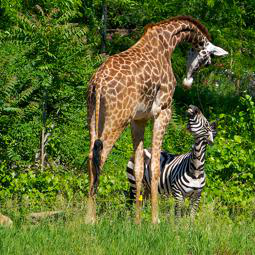

In [15]:
thumb

In [16]:
import IPython.display

[X] hash : /tmp/darknet/data/giraffe.jpg
[X] thumb : /tmp/darknet/data/giraffe.jpg
Loading network......Done
Loading metadata......Done
99.33% giraffe


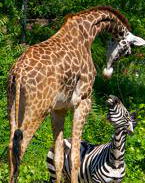

99.92% zebra


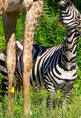

[X] hash : /tmp/darknet/data/person.jpg
[X] thumb : /tmp/darknet/data/person.jpg
99.97% horse


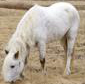

99.94% dog


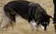

99.98% person


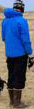

[X] hash : /tmp/darknet/data/eagle.jpg
[X] thumb : /tmp/darknet/data/eagle.jpg
99.90% bird


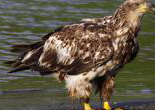

[X] hash : /tmp/darknet/data/scream.jpg
[X] thumb : /tmp/darknet/data/scream.jpg
[X] hash : /tmp/darknet/data/kite.jpg
[X] thumb : /tmp/darknet/data/kite.jpg
99.30% person


87.24% person


99.01% person


73.75% person


[X] hash : /tmp/darknet/data/dog.jpg
[X] thumb : /tmp/darknet/data/dog.jpg
99.83% dog


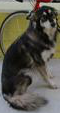

81.59% bench


99.55% truck


99.76% bicycle


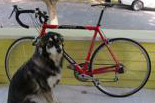

[X] hash : /tmp/darknet/data/horses.jpg
[X] thumb : /tmp/darknet/data/horses.jpg
99.83% horse


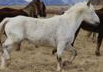

99.89% horse


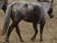

96.58% horse


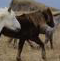

In [17]:
for file_path in images:
    thumb = utils.pil_thumbnail(get_thumbnail(file_path))
    dets = classifier.detect(thumb)
    for det in dets:
        print("{:.2f}% {}".format(100*det.detection.objectness, det.classification))
        IPython.display.display(det.crop)

In [18]:
file_path

'/tmp/darknet/data/horses.jpg'

In [19]:
utils.get_objects(file_path=file_path)

['horse', 'horse', 'horse', 'horse']

In [78]:
if not redis_db.objects.exists(file_hash):
    for det in dets:
        redis_db.objects.lpush(file_hash, det.classification)

In [68]:
dets = classifier.detect(thumb)
dets

[Classified<horse, (4.462688446044922, 62.92995071411133, 107.10375595092773, 135.07708358764648)>,
 Classified<horse, (142.44261932373047, 70.68855094909668, 198.76758575439453, 114.33381843566895)>,
 Classified<horse, (82.55363464355469, 56.875789642333984, 143.44601440429688, 117.65375137329102)>]

0.9982613325119019


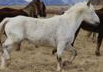

0.998893678188324


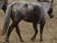

0.9658085107803345


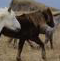

In [70]:
for det in dets:
    print(det.detection.objectness)
    IPython.display.display(det.crop)

In [71]:
file_hash = redis_db.xxhash.get(image).decode()
file_hash

'7b05a249329cf220'

True

In [48]:
if not redis_db.objects.exists(file_hash):
    for det in dets:
        redis_db.objects.lpush(file_hash, det.classification)

In [72]:
objects = redis_db.objects.lrange(start=0, end=-1, name=file_hash)
objects

[b'horse', b'horse', b'horse']

In [59]:
def get_objects(file_path, **kwargs):
    if isinstance(file_path, bytes):
        file_path = file_path.decode("UTF-8")
    file_path = str(file_path)

    file_hash = get_xxhash(file_path)

    if redis_db.objects.exists(file_hash):
        objects_ = redis_db.thumb.get(file_hash)
        print("[X] objects : {}".format(file_path))
    else:
        objects_ = utils.get_objects(file_path, pil_image=False)
        redis_db.thumb.set(file_hash, thumb_)
        print("[ ] thumb : {}".format(file_path))

    return thumb_

In [53]:
dets = classifier.detect(file_path)

NameError: name 'file_path' is not defined

In [ ]:
def get_objects(file_path, **kwargs):
    

In [45]:
redis_db.xxhash.exists(image)

True

In [48]:
file_hash = get_xxhash(image)

[X] hash : /tmp/darknet/data/giraffe.jpg


In [49]:
redis_db.objects.lrange(start=0, end=-1, name=file_hash)

[b'zebra', b'giraffe']

In [50]:
redis_db.objects.lrange(start=0, end=-1, name="foo")

[]

In [51]:
objs = redis_db.objects.lrange(start=0, end=-1, name=file_hash)
objs

[b'zebra', b'giraffe']

In [55]:
det.classification.encode("UTF-8") not in objs

False

In [56]:
if det.classification.encode("UTF-8") not in objs:
    redis_db.objects.lpush(image_hash, det.classification)